In [1]:
import numpy as np
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid, Tanh

In [2]:
%matplotlib inline

In [3]:
device=t.device('cpu') #Overrride the above device choice

### Generate the sample 2D distribution: uniform from unit circle.  

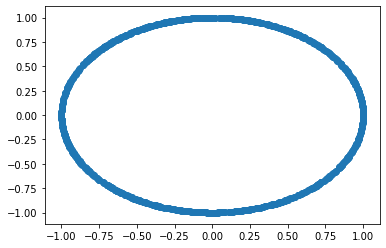

In [4]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
plt.scatter(data[:,0], data[:,1])

### GAN implementation

In [5]:
discriminator = Sequential(
    Linear(2,100),  
    LeakyReLU(0.2),
    
    Linear(100, 50), 
    LeakyReLU(0.2),
    
    Linear(50, 25), 
    LeakyReLU(0.2),
    
    Linear(25, 1), 
    Sigmoid()
)

In [6]:
generator = Sequential(
    Linear(2,250),
    Dropout(0.25),
    LeakyReLU(0.1),
    
    Linear(250,125),
    Dropout(0.25),
    LeakyReLU(0.1),
    
    Linear(125,100),
    Dropout(0.25),
    LeakyReLU(0.1),
    
    Linear(100,50),
    Dropout(0.25),
    LeakyReLU(0.1),
    
    Linear(50, 2),    
)

## Starting here

In [7]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = t.ones(size, 1)

    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = t.zeros(size, 1)

    return data

In [8]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake

In [9]:
def train_generator(optimizer, fake_data):
    # Train Generator
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [10]:
def show(noise, fake, real):
    
    fig, axs = plt.subplots(1,3, figsize = (12,4))
    
    for ax in axs:
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim((-1.5,1.5))
    
    axs[0].set_title("noise")
    axs[1].set_title("fake")
    axs[2].set_title("real")
    
    axs[0].scatter(noise.data.cpu().numpy()[:,0],noise.data.cpu().numpy()[:,1], color = 'gray')
    axs[1].scatter(fake.data.cpu().numpy()[:,0], fake.data.cpu().numpy()[:,1], color = 'red')
    axs[2].scatter(real.data.cpu().numpy()[:,0], real.data.cpu().numpy()[:,1], color = 'green')

    fig.tight_layout()
    plt.show()

## Starting the training:

In [11]:
discriminator = discriminator.to(device) 
generator= generator.to(device)

d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.00002)
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.00002)

loss = t.nn.BCELoss()

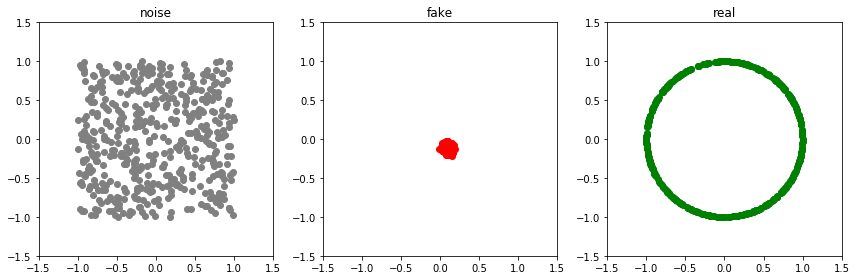

Epoch: 0 G-error: 0.6188268065452576 D-error: 1.3825496435165405


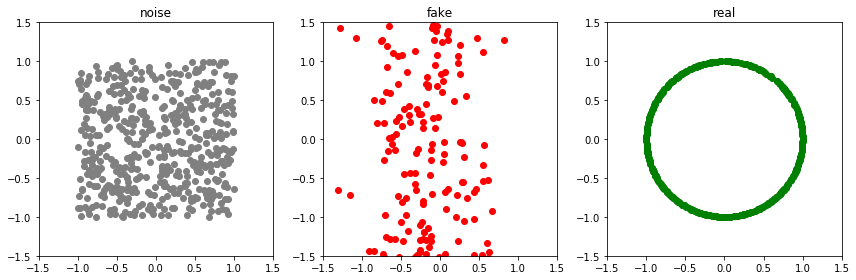

Epoch: 10000 G-error: 0.8718195557594299 D-error: 0.9490136504173279


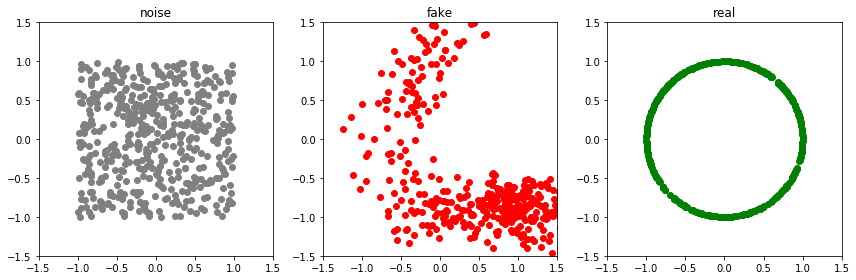

Epoch: 20000 G-error: 0.7367650866508484 D-error: 0.4951205551624298


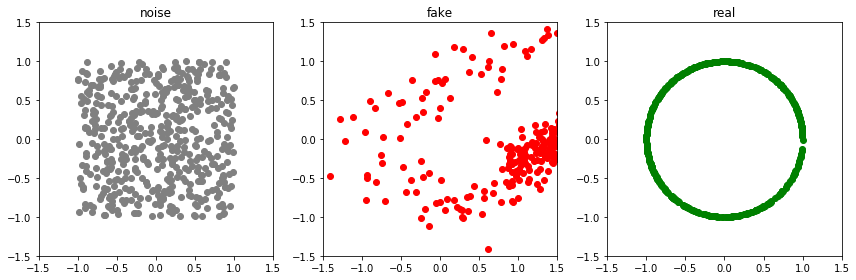

Epoch: 30000 G-error: 0.8518573045730591 D-error: 0.4475456476211548


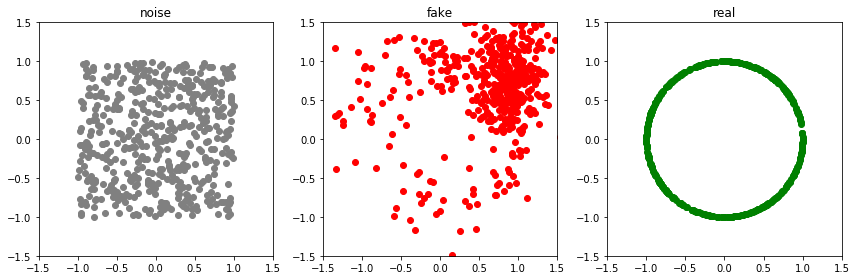

Epoch: 40000 G-error: 1.3910448551177979 D-error: 0.37586063146591187


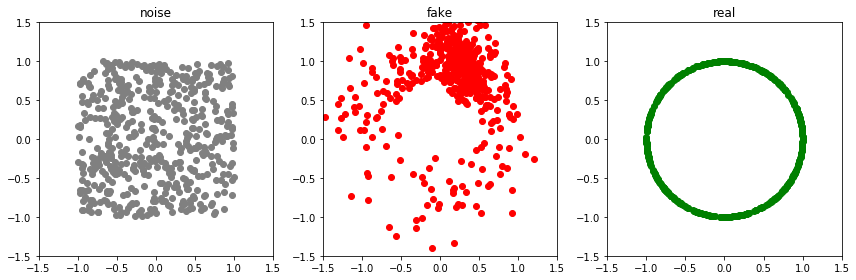

Epoch: 50000 G-error: 2.3986802101135254 D-error: 0.42776182293891907


In [12]:
num_epochs = 60000
sample_size = 500

for epoch in range(num_epochs):
    
    # real data
    angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
    data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
    real_data = t.from_numpy(data)
    
    # train discriminator:
    noise = t.empty(sample_size,2, device=device).uniform_(-1,-1)  
    fake_data = generator(noise)  
    d_error = train_discriminator(d_optimizer, real_data, fake_data)
    

    # train generator     
    if epoch%8 ==0:
        noise = t.empty(sample_size,2, device=device).uniform_(-1,1)  
        fake_data = generator(noise)  
        g_error = train_generator(g_optimizer, fake_data)
 
    
    if epoch%10000 ==0:
        show(noise, fake_data, real_data)
        print(f"Epoch: {epoch} G-error: {g_error.item()} D-error: {d_error.item()}")


## Training only the generator:

In [14]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.00001)
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.00001)

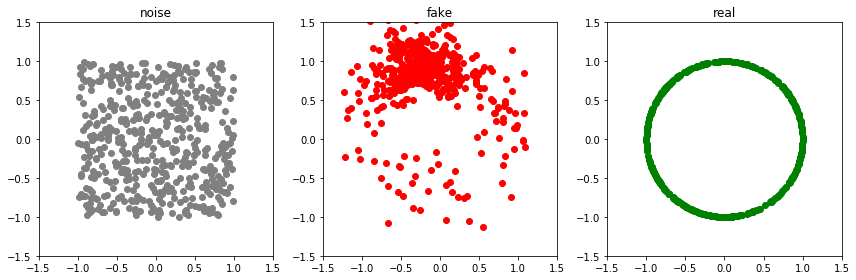

Epoch: 0 G-error: 3.12691330909729 D-error: 0.31845104694366455


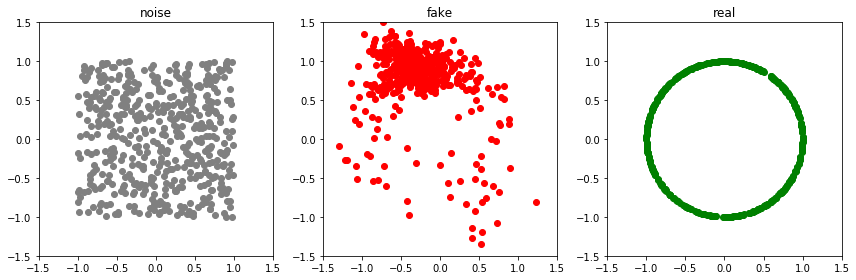

Epoch: 1000 G-error: 3.156827688217163 D-error: 0.3788628578186035


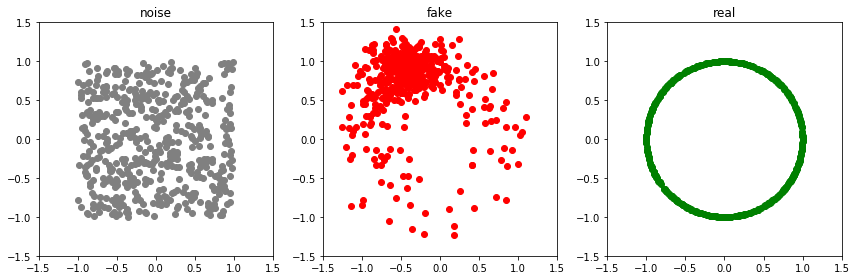

Epoch: 2000 G-error: 3.0240116119384766 D-error: 0.3718946874141693


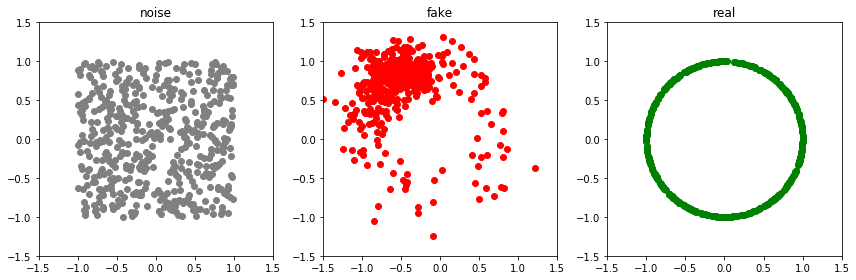

Epoch: 3000 G-error: 2.8687636852264404 D-error: 0.3811224102973938


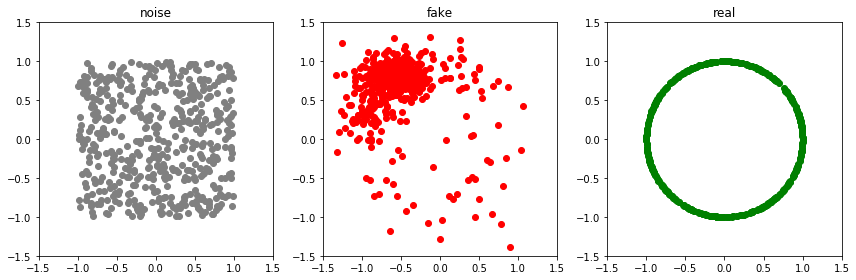

Epoch: 4000 G-error: 3.1880414485931396 D-error: 0.36676526069641113


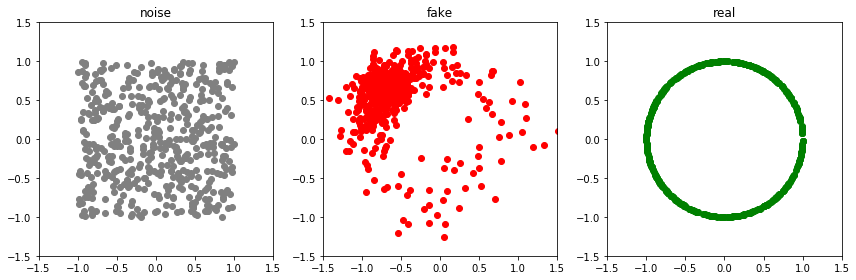

Epoch: 5000 G-error: 3.3199594020843506 D-error: 0.3502114415168762


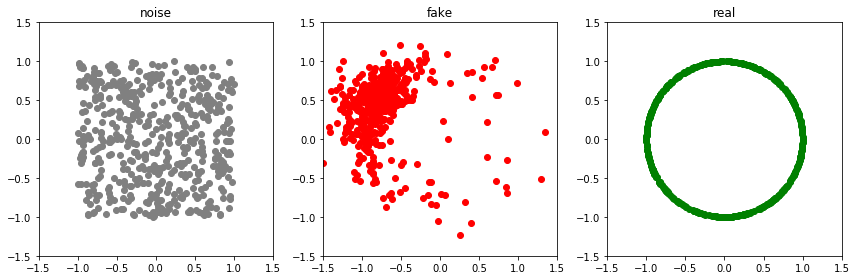

Epoch: 6000 G-error: 3.33189058303833 D-error: 0.3607306480407715


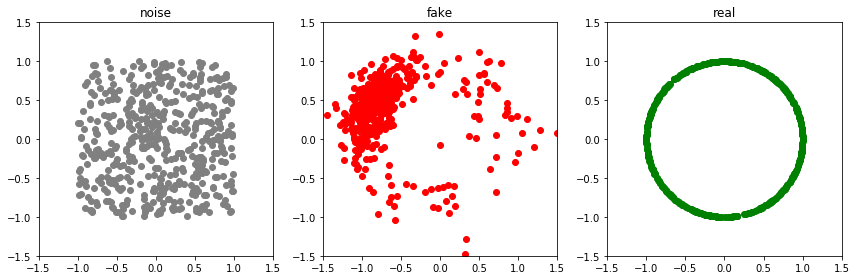

Epoch: 7000 G-error: 3.1315629482269287 D-error: 0.353866308927536


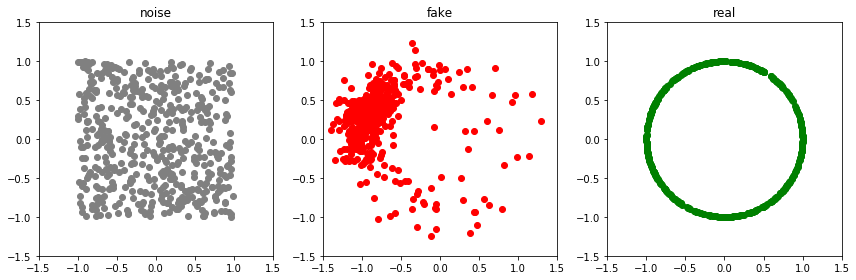

Epoch: 8000 G-error: 3.0770862102508545 D-error: 0.36379072070121765


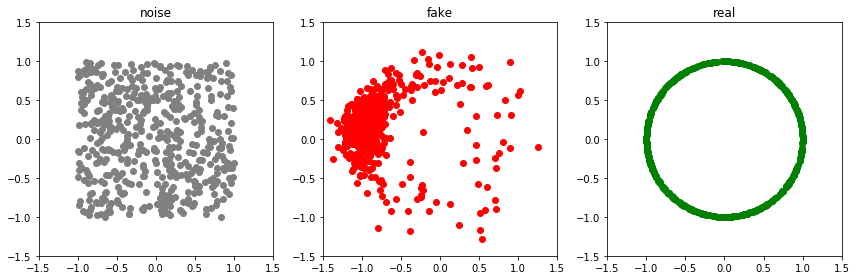

Epoch: 9000 G-error: 2.9563307762145996 D-error: 0.3234843611717224


In [15]:
num_epochs = 10000
sample_size = 500

for epoch in range(num_epochs):
    
    # real data
    angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
    data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
    real_data = t.from_numpy(data)
    
    # train discriminator:
    noise = t.empty(sample_size,2, device=device).uniform_(-1,-1)  
    fake_data = generator(noise)  
    d_error = train_discriminator(d_optimizer, real_data, fake_data)
    

    # train generator     
    noise = t.empty(sample_size,2, device=device).uniform_(-1,1)  
    fake_data = generator(noise)  
    g_error = train_generator(g_optimizer, fake_data)
 
    
    if epoch%1000 ==0:
        show(noise, fake_data, real_data)
        print(f"Epoch: {epoch} G-error: {g_error.item()} D-error: {d_error.item()}")


In [16]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.000005)
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.000005)

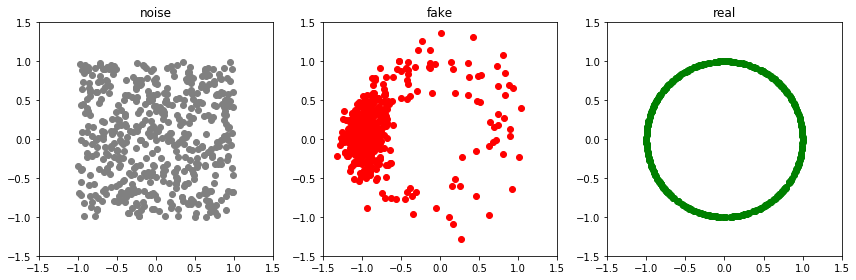

Epoch: 0 G-error: 3.010402202606201 D-error: 0.34818416833877563


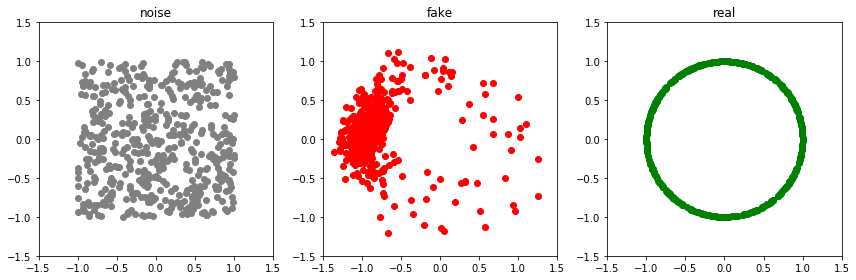

Epoch: 100 G-error: 3.404677391052246 D-error: 0.3879849910736084


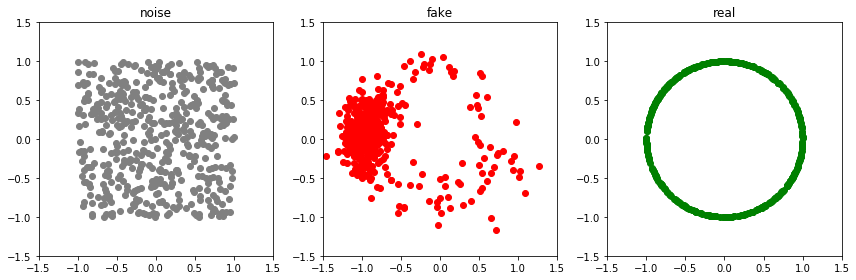

Epoch: 200 G-error: 3.6340816020965576 D-error: 0.3414835035800934


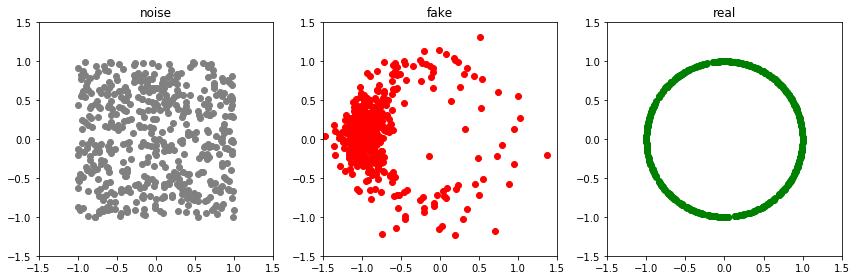

Epoch: 300 G-error: 3.3849711418151855 D-error: 0.3402360677719116


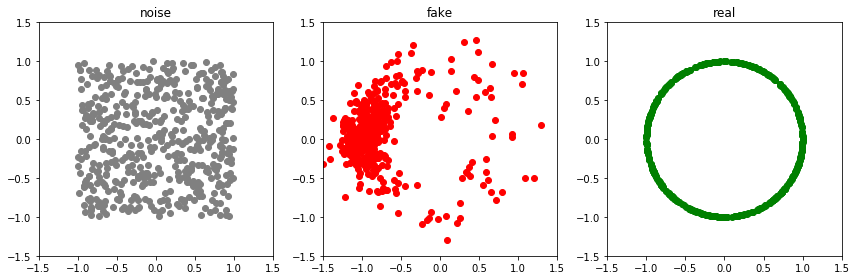

Epoch: 400 G-error: 3.7125699520111084 D-error: 0.3226562440395355


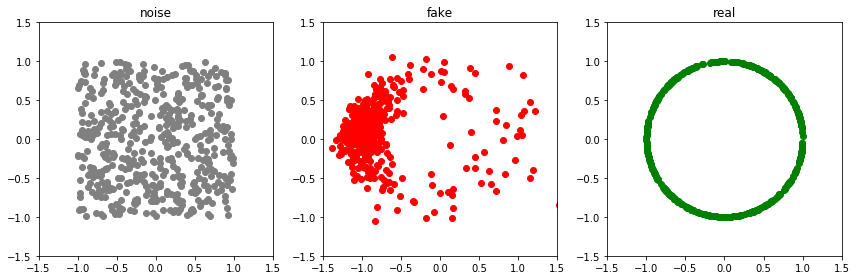

Epoch: 500 G-error: 3.5545499324798584 D-error: 0.35579726099967957


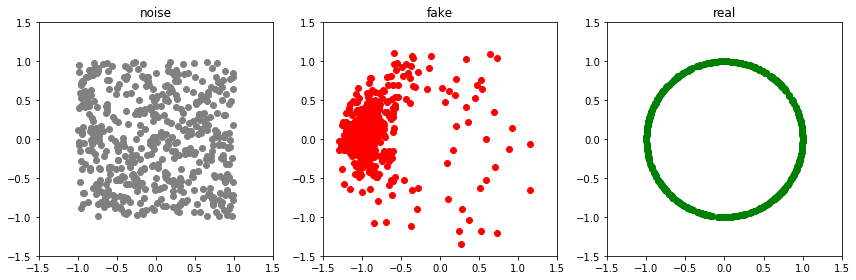

Epoch: 600 G-error: 3.75297474861145 D-error: 0.3402103781700134


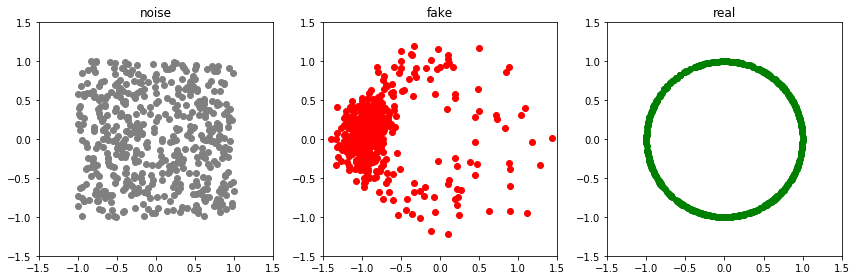

Epoch: 700 G-error: 3.9343996047973633 D-error: 0.31986725330352783


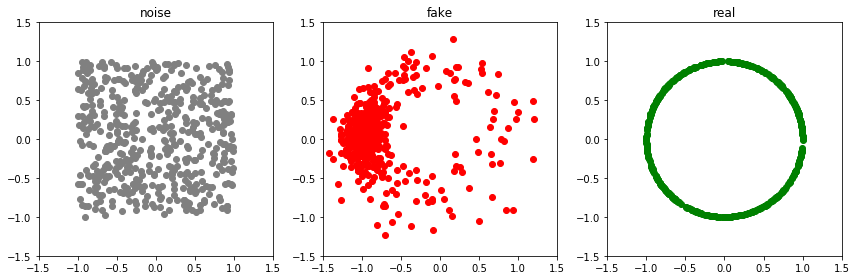

Epoch: 800 G-error: 3.837343692779541 D-error: 0.3381807208061218


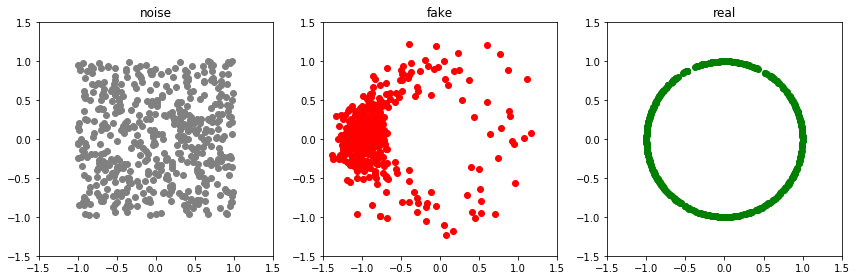

Epoch: 900 G-error: 3.600203514099121 D-error: 0.3168371319770813


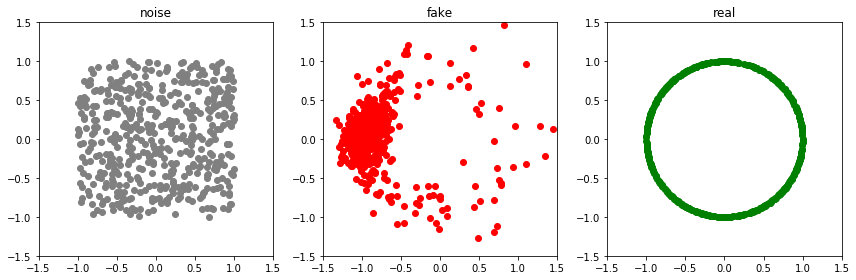

Epoch: 1000 G-error: 3.8726511001586914 D-error: 0.32894954085350037


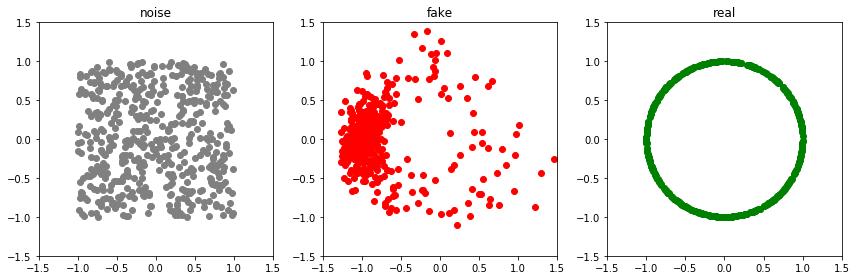

Epoch: 1100 G-error: 3.6761558055877686 D-error: 0.3423309326171875


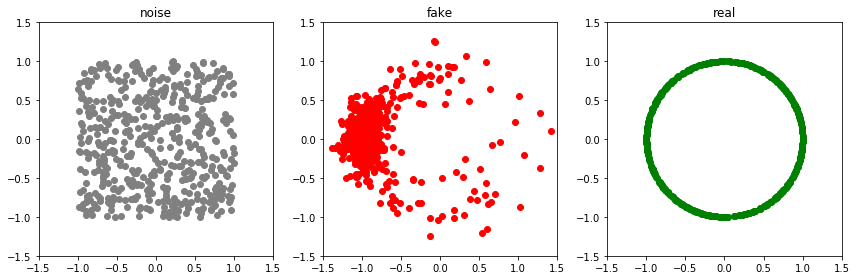

Epoch: 1200 G-error: 3.6450538635253906 D-error: 0.3424515128135681


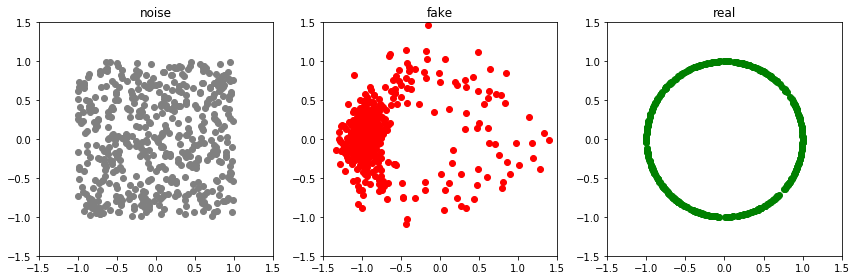

Epoch: 1300 G-error: 3.772279977798462 D-error: 0.33475005626678467


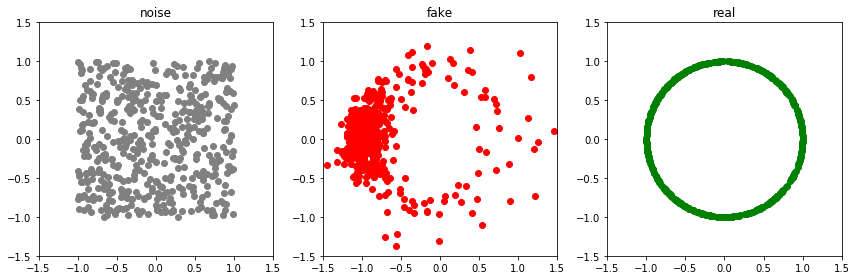

Epoch: 1400 G-error: 3.58664870262146 D-error: 0.3552016615867615


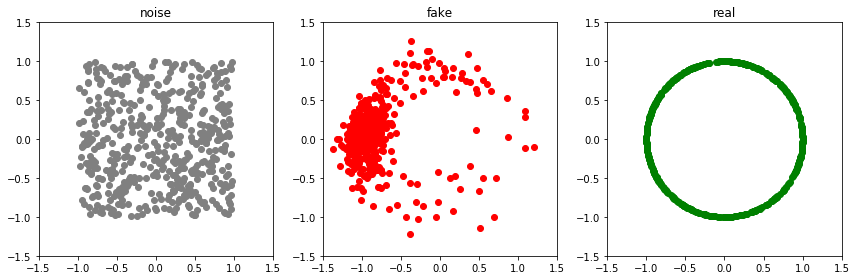

Epoch: 1500 G-error: 3.1747984886169434 D-error: 0.34473392367362976


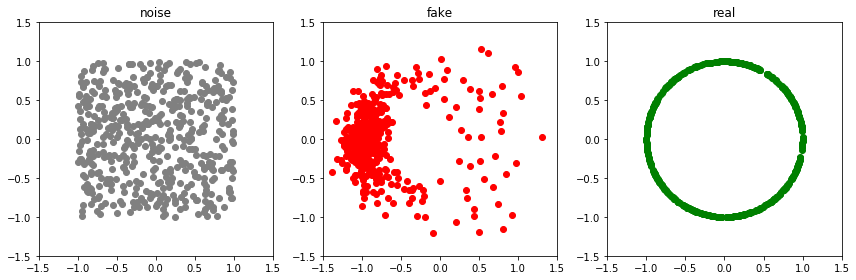

Epoch: 1600 G-error: 3.7491230964660645 D-error: 0.34624361991882324


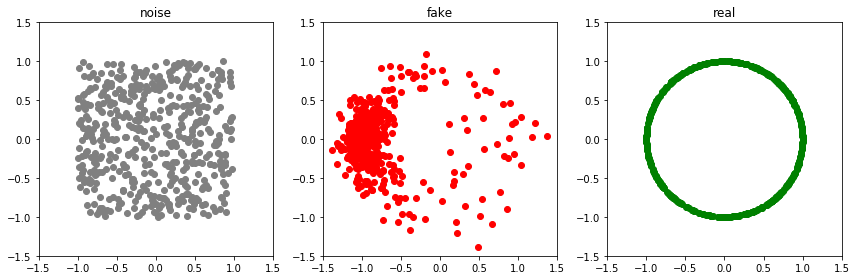

Epoch: 1700 G-error: 3.791639566421509 D-error: 0.3423807919025421


Epoch: 1800 G-error: 3.766732931137085 D-error: 0.34453949332237244


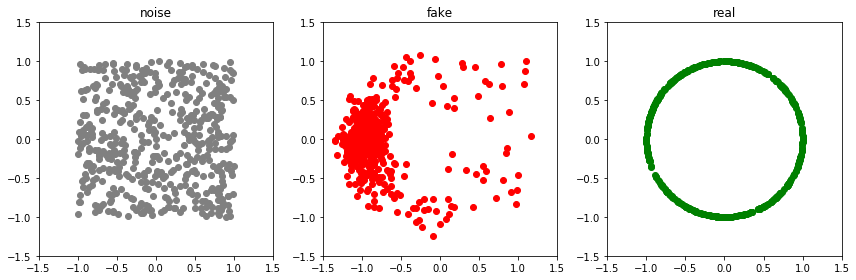

Epoch: 1900 G-error: 3.4415786266326904 D-error: 0.3347979187965393


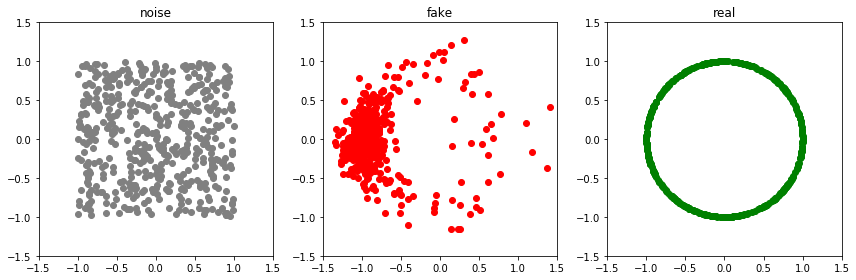

Epoch: 2000 G-error: 3.5914812088012695 D-error: 0.3720484972000122


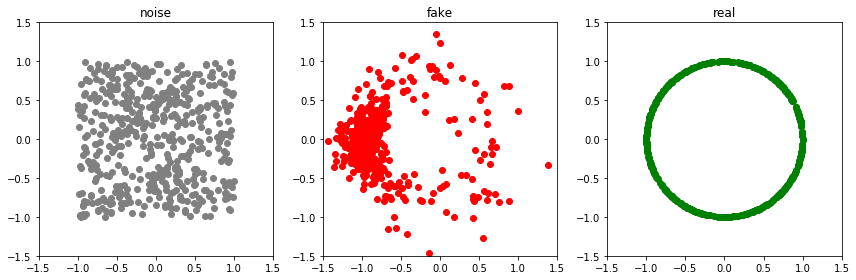

Epoch: 2100 G-error: 4.0176286697387695 D-error: 0.3481918275356293


Epoch: 2200 G-error: 3.811251401901245 D-error: 0.31613877415657043


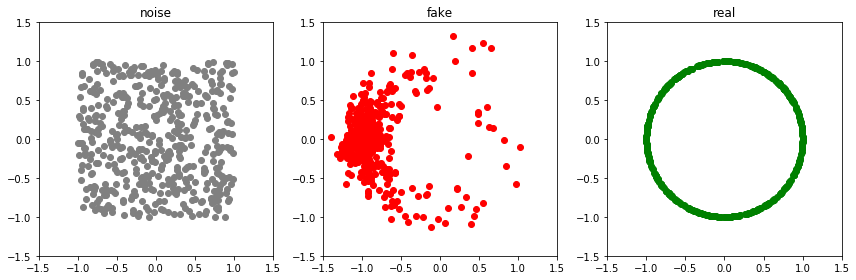

Epoch: 2300 G-error: 3.424368143081665 D-error: 0.33340877294540405


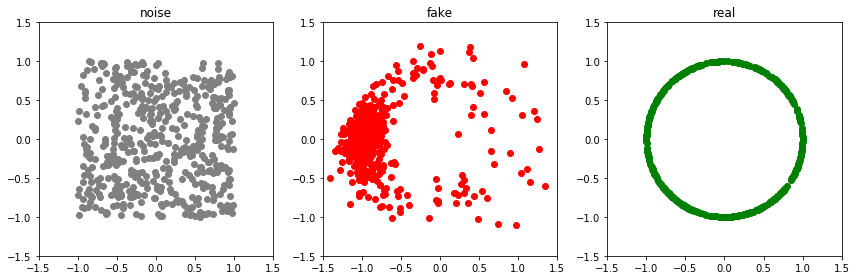

Epoch: 2400 G-error: 3.750523328781128 D-error: 0.3570749759674072


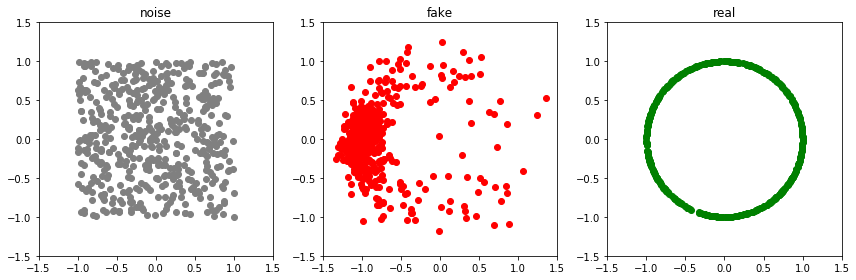

Epoch: 2500 G-error: 3.7123491764068604 D-error: 0.3409246802330017


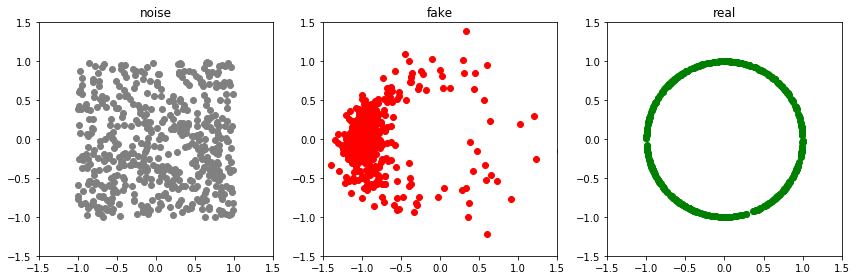

Epoch: 2600 G-error: 3.6985909938812256 D-error: 0.3229202628135681


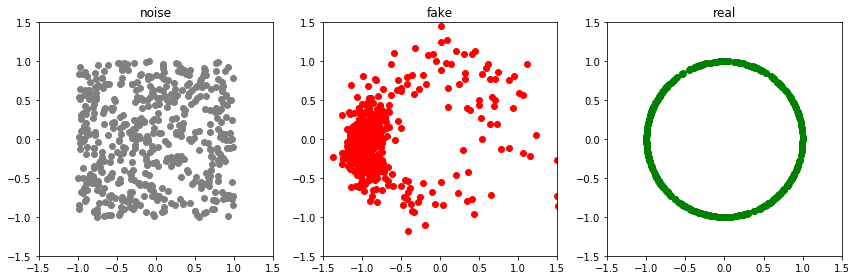

Epoch: 2700 G-error: 3.8494696617126465 D-error: 0.34014713764190674


Epoch: 2800 G-error: 3.7730932235717773 D-error: 0.3127613663673401


Epoch: 2900 G-error: 3.922503709793091 D-error: 0.3220677375793457


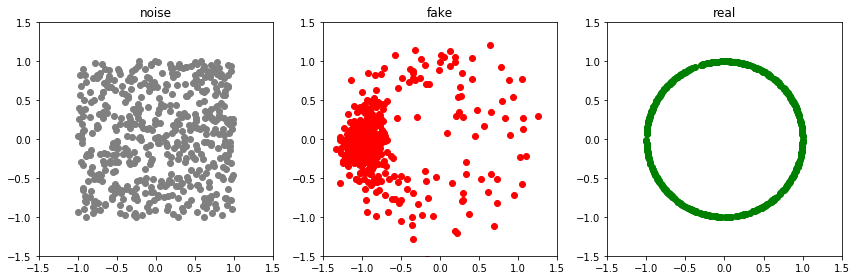

Epoch: 3000 G-error: 3.796360492706299 D-error: 0.31566715240478516


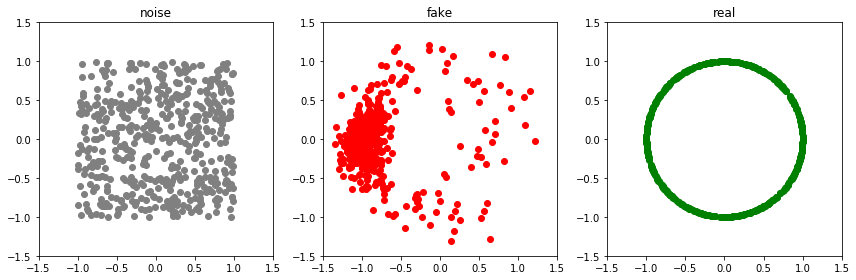

Epoch: 3100 G-error: 3.8384716510772705 D-error: 0.3583146929740906


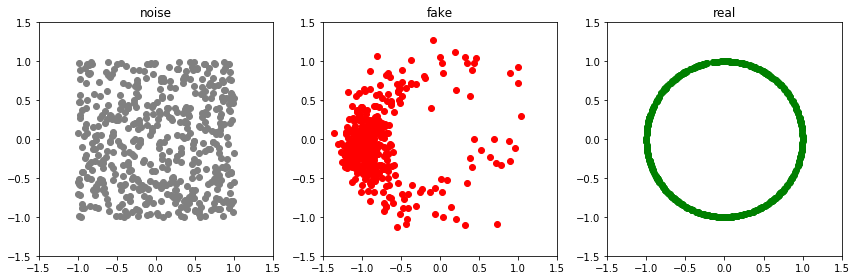

Epoch: 3200 G-error: 3.8094089031219482 D-error: 0.3263894319534302


Epoch: 3300 G-error: 3.343898296356201 D-error: 0.29430243372917175


Epoch: 3400 G-error: 3.9512338638305664 D-error: 0.31071990728378296


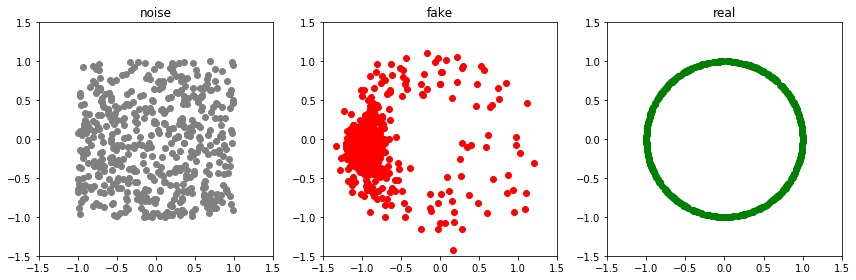

Epoch: 3500 G-error: 3.5322601795196533 D-error: 0.35038143396377563


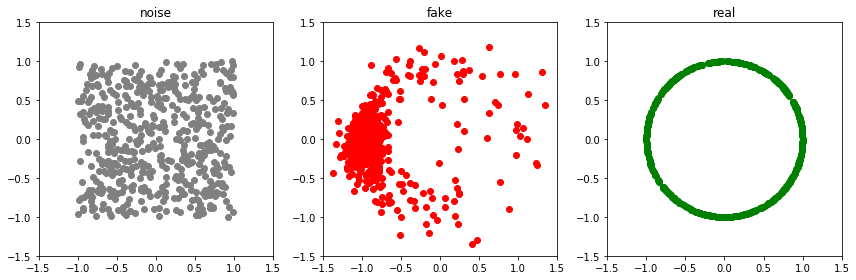

Epoch: 3600 G-error: 3.758807897567749 D-error: 0.3338015079498291


Epoch: 3700 G-error: 3.714646100997925 D-error: 0.333545982837677


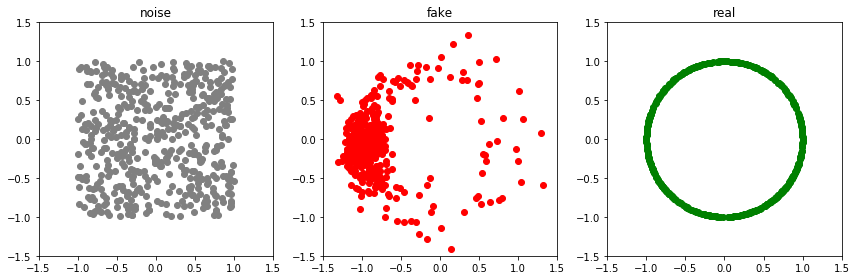

Epoch: 3800 G-error: 3.3543922901153564 D-error: 0.35000520944595337


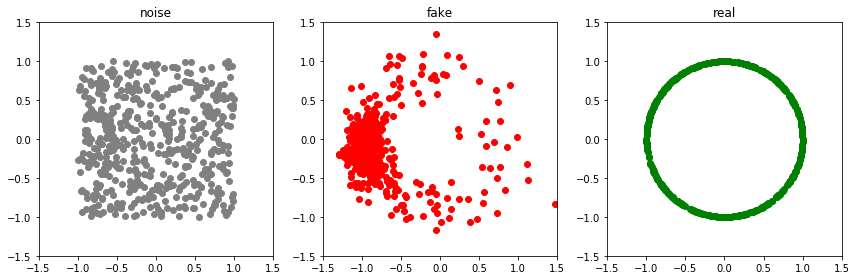

Epoch: 3900 G-error: 3.4126675128936768 D-error: 0.38787418603897095


Epoch: 4000 G-error: 3.528606414794922 D-error: 0.3039051294326782


Epoch: 4100 G-error: 3.5460727214813232 D-error: 0.3393072485923767


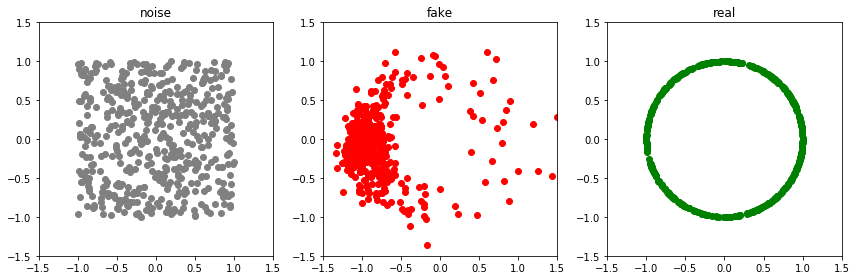

Epoch: 4200 G-error: 3.7768378257751465 D-error: 0.31924331188201904


Epoch: 4300 G-error: 3.678196430206299 D-error: 0.3268083333969116


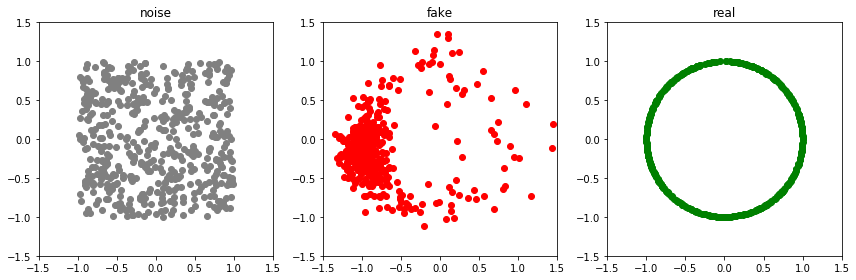

Epoch: 4400 G-error: 3.3026633262634277 D-error: 0.3657531142234802


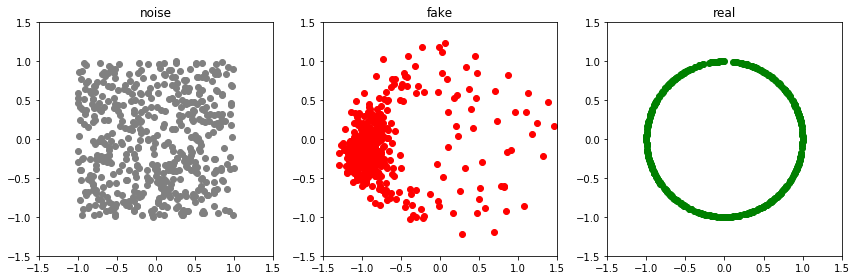

Epoch: 4500 G-error: 3.7804789543151855 D-error: 0.3441033959388733


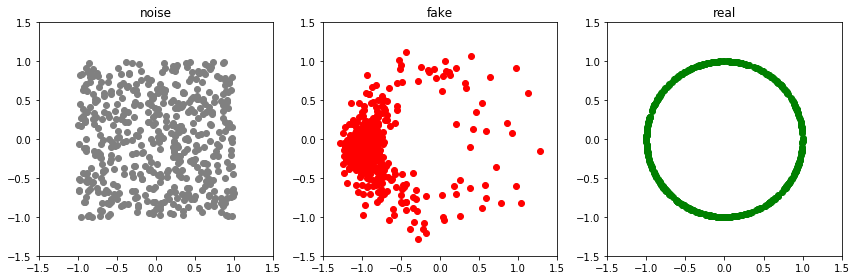

Epoch: 4600 G-error: 3.581691265106201 D-error: 0.3169248104095459


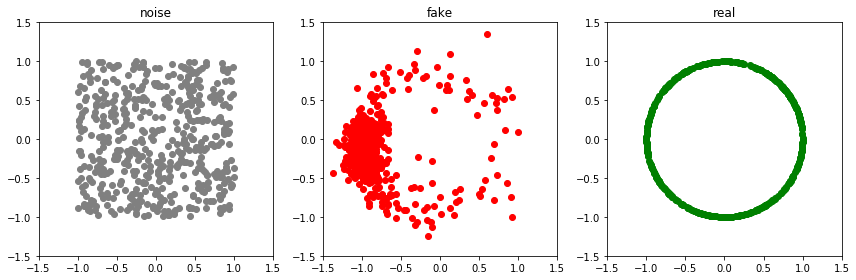

Epoch: 4700 G-error: 3.337284564971924 D-error: 0.3419126272201538


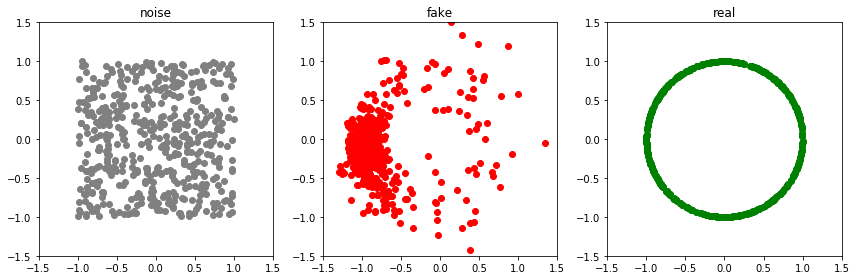

Epoch: 4800 G-error: 3.7613308429718018 D-error: 0.3594512641429901


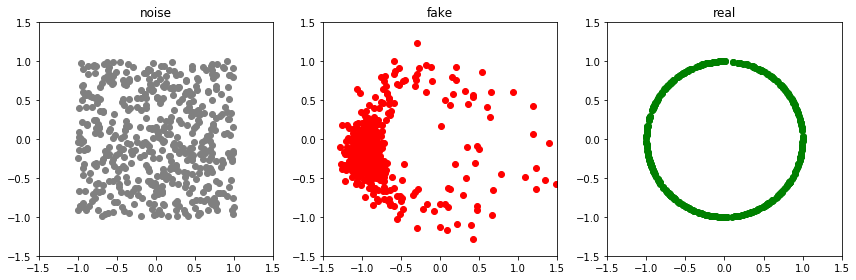

Epoch: 4900 G-error: 3.4616212844848633 D-error: 0.3241729736328125


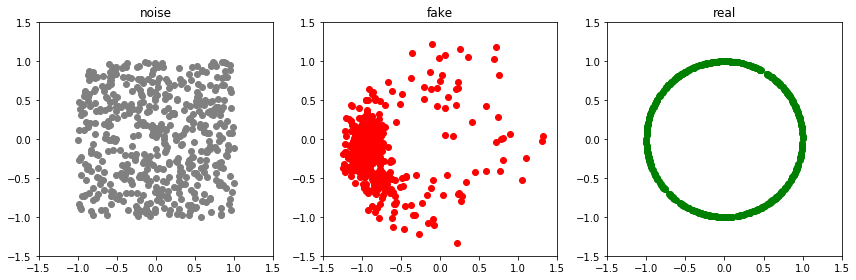

Epoch: 5000 G-error: 3.547706365585327 D-error: 0.35546544194221497


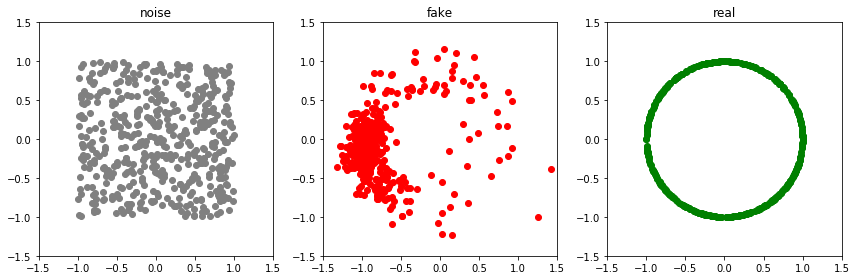

Epoch: 5100 G-error: 3.636842966079712 D-error: 0.3280661106109619


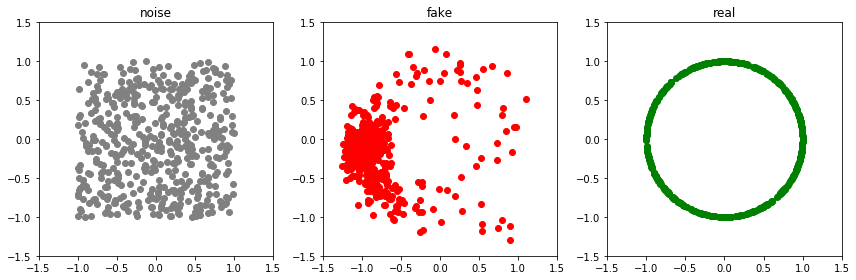

Epoch: 5200 G-error: 3.7252495288848877 D-error: 0.32095271348953247


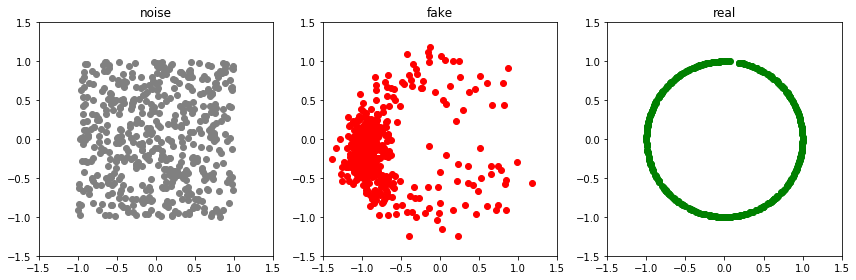

Epoch: 5300 G-error: 3.804781198501587 D-error: 0.33144766092300415


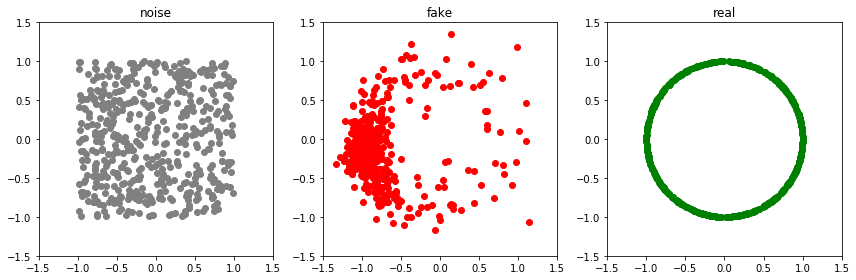

Epoch: 5400 G-error: 3.54679536819458 D-error: 0.35862278938293457


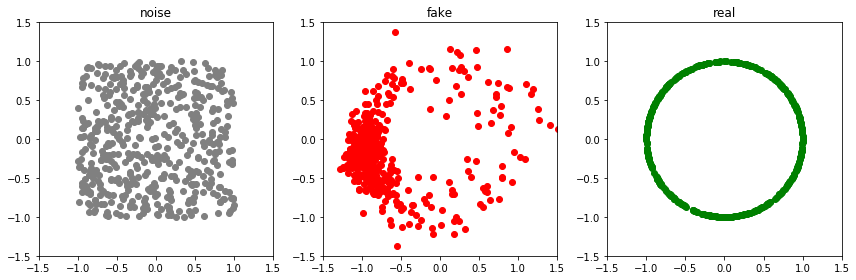

Epoch: 5500 G-error: 3.3715977668762207 D-error: 0.3254774212837219


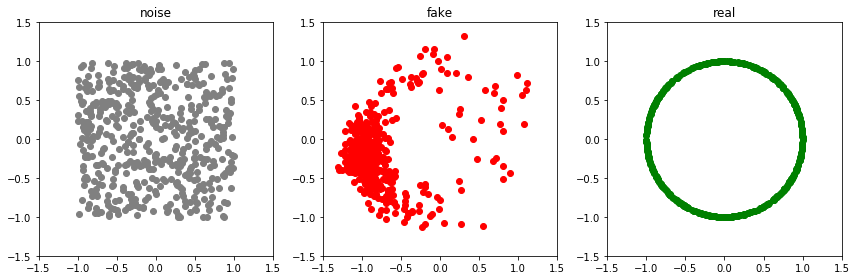

Epoch: 5600 G-error: 3.3032703399658203 D-error: 0.31219232082366943


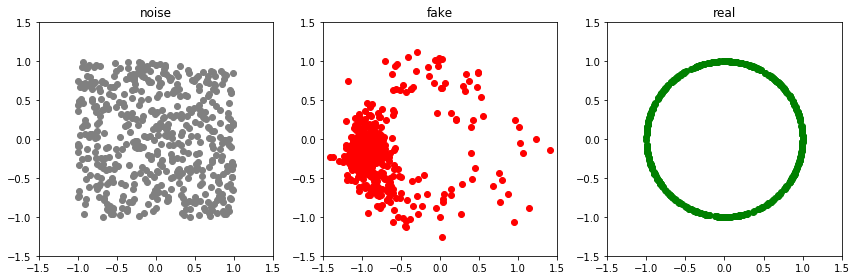

Epoch: 5700 G-error: 3.9379231929779053 D-error: 0.3273146152496338


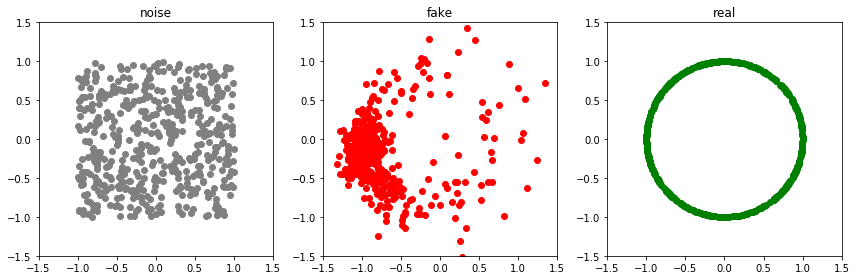

Epoch: 5800 G-error: 3.859630584716797 D-error: 0.3342459797859192


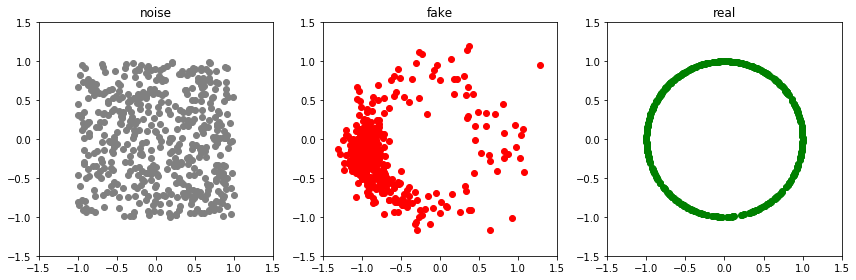

Epoch: 5900 G-error: 3.1498844623565674 D-error: 0.36510759592056274


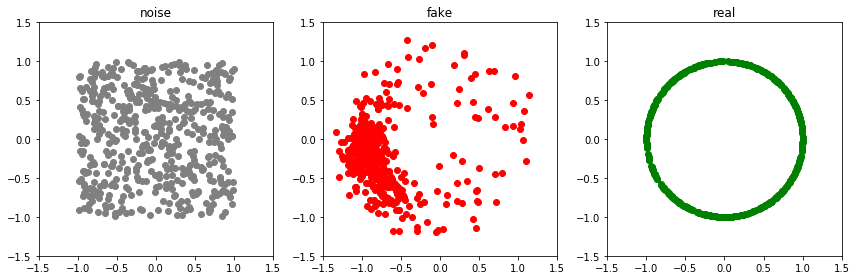

Epoch: 6000 G-error: 3.7125163078308105 D-error: 0.3052179217338562


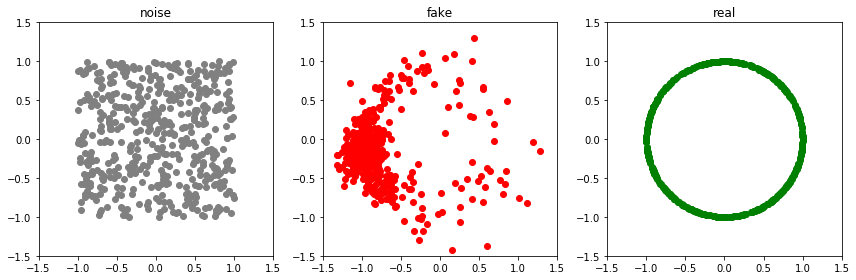

Epoch: 6100 G-error: 3.5619797706604004 D-error: 0.2953101396560669


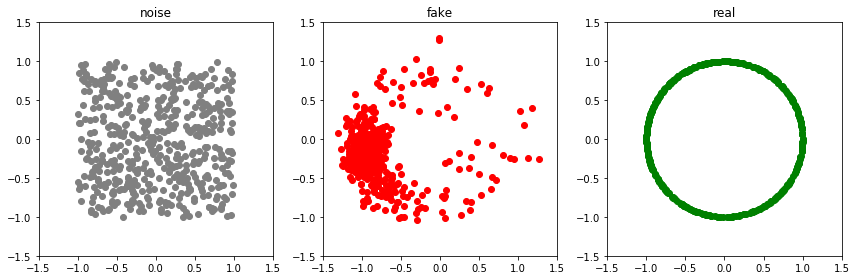

Epoch: 6200 G-error: 3.730940341949463 D-error: 0.3486679792404175


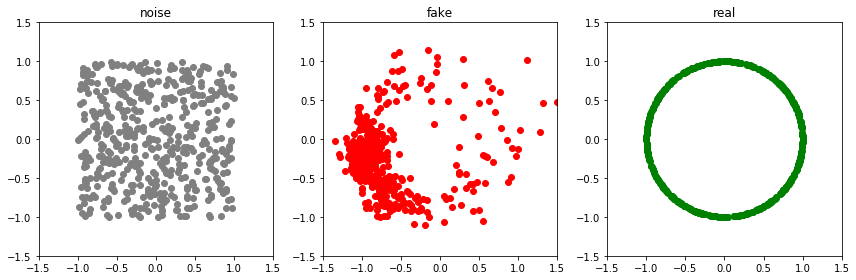

Epoch: 6300 G-error: 3.6092631816864014 D-error: 0.3416514992713928


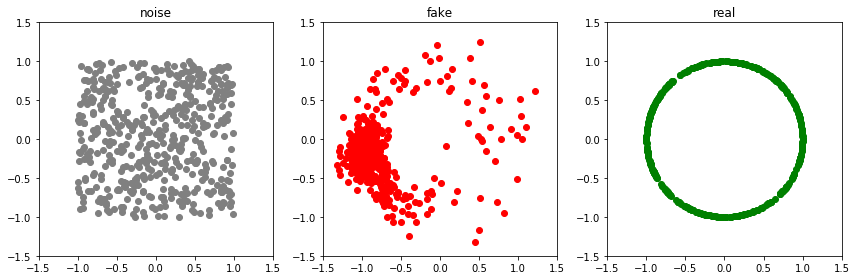

Epoch: 6400 G-error: 3.4891879558563232 D-error: 0.32755500078201294


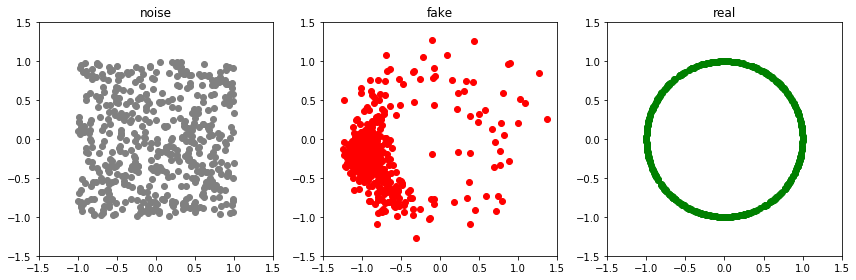

Epoch: 6500 G-error: 3.663957118988037 D-error: 0.31601738929748535


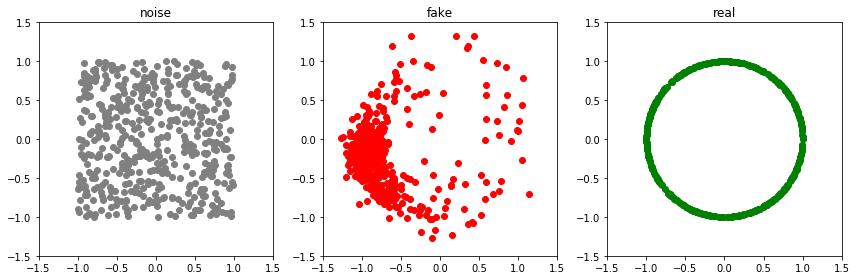

Epoch: 6600 G-error: 3.346956253051758 D-error: 0.36657941341400146


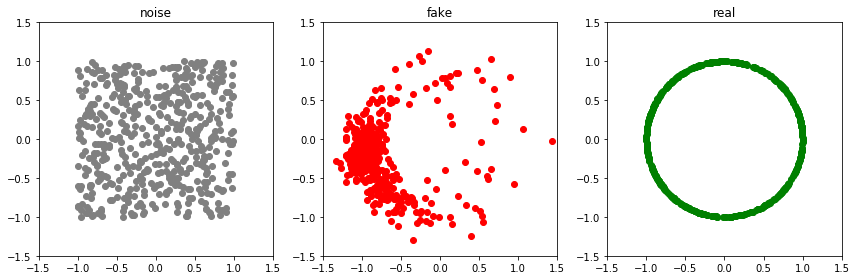

Epoch: 6700 G-error: 3.4082911014556885 D-error: 0.341008722782135


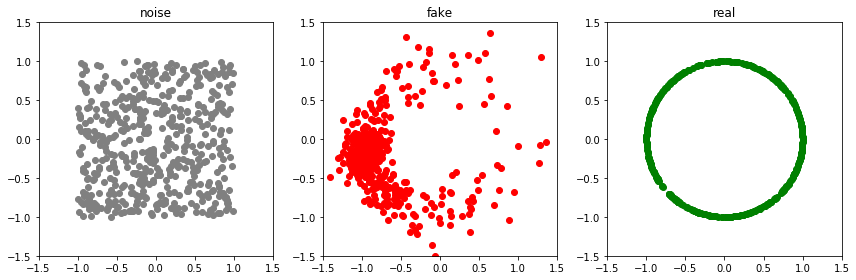

Epoch: 6800 G-error: 3.7413229942321777 D-error: 0.31335699558258057


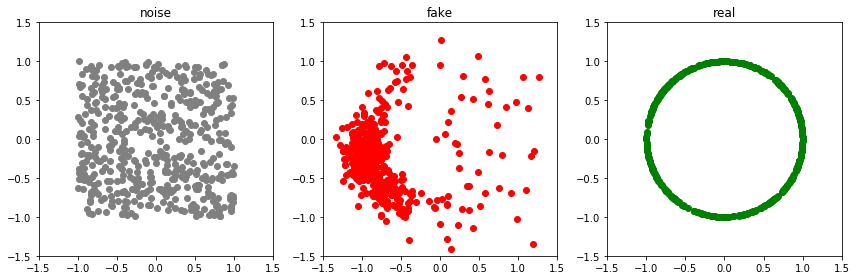

Epoch: 6900 G-error: 3.790088415145874 D-error: 0.3288456201553345


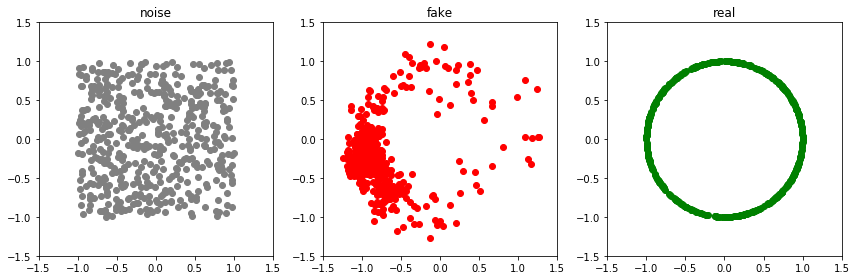

Epoch: 7000 G-error: 3.1989152431488037 D-error: 0.3637316823005676


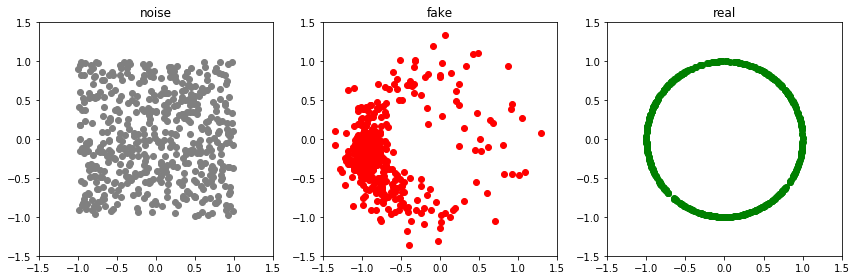

Epoch: 7100 G-error: 4.14177131652832 D-error: 0.34642425179481506


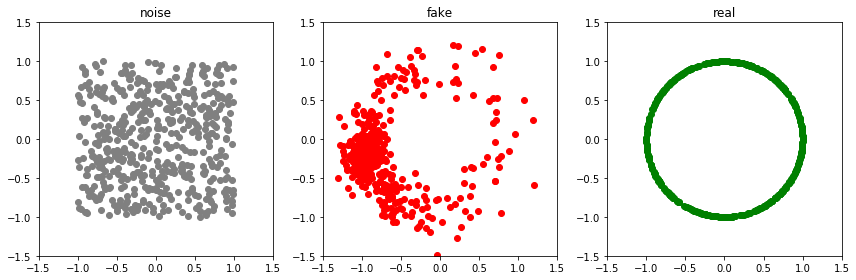

Epoch: 7200 G-error: 3.501734733581543 D-error: 0.29922306537628174


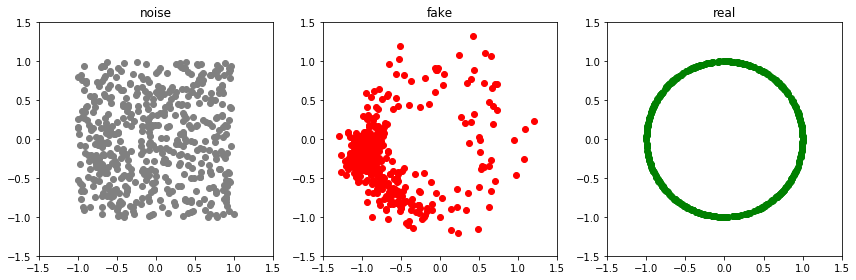

Epoch: 7300 G-error: 3.3781557083129883 D-error: 0.3475436270236969


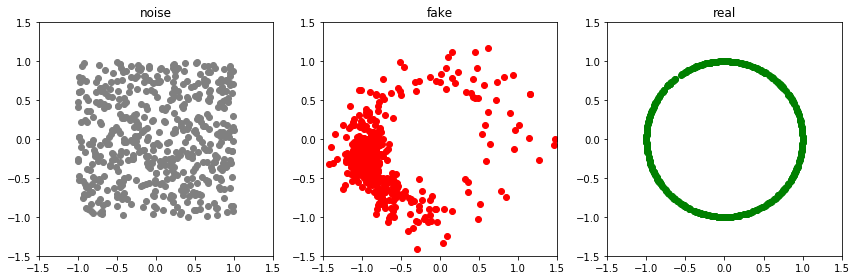

Epoch: 7400 G-error: 3.528747797012329 D-error: 0.3338647186756134


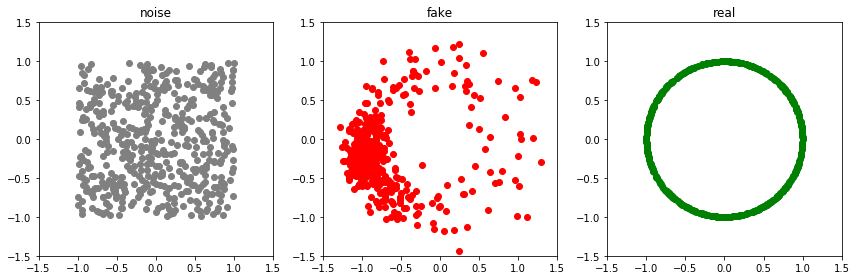

Epoch: 7500 G-error: 3.8416554927825928 D-error: 0.33690041303634644


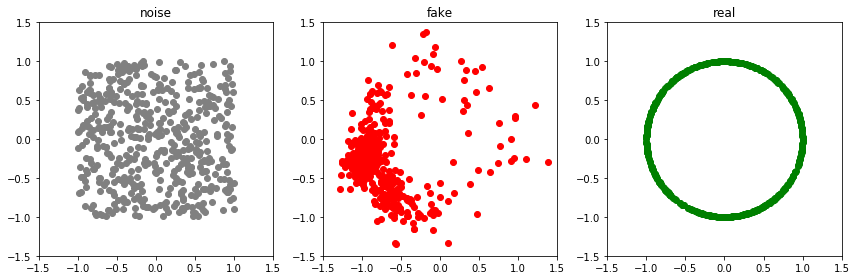

Epoch: 7600 G-error: 3.528129816055298 D-error: 0.3422994315624237


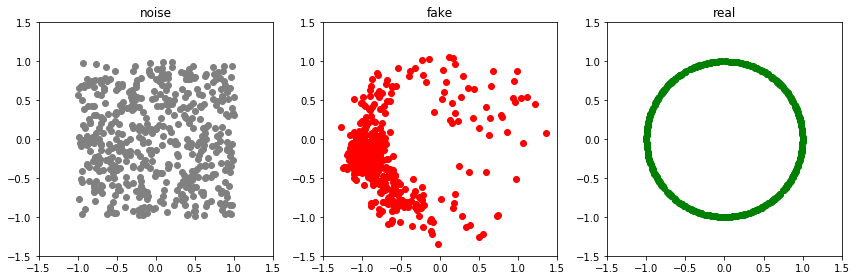

Epoch: 7700 G-error: 3.404003858566284 D-error: 0.31645822525024414


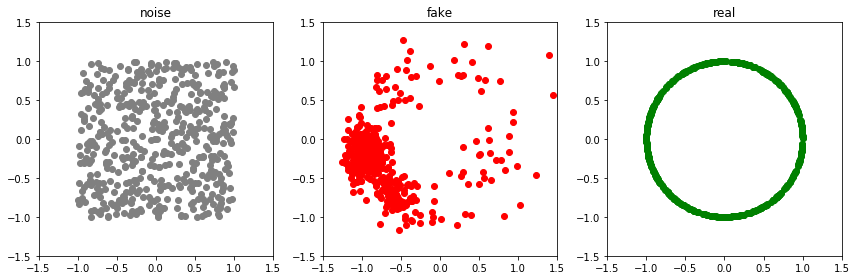

Epoch: 7800 G-error: 3.6634554862976074 D-error: 0.34260496497154236


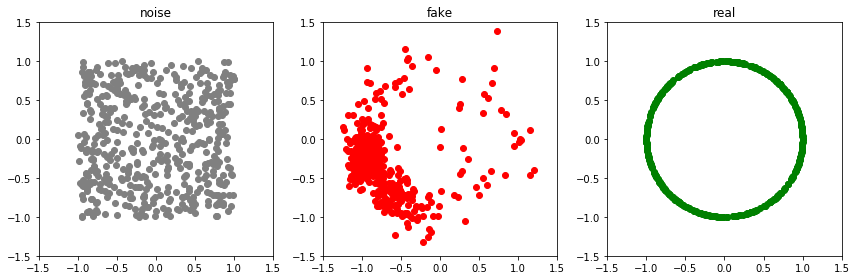

Epoch: 7900 G-error: 3.2503058910369873 D-error: 0.33406883478164673


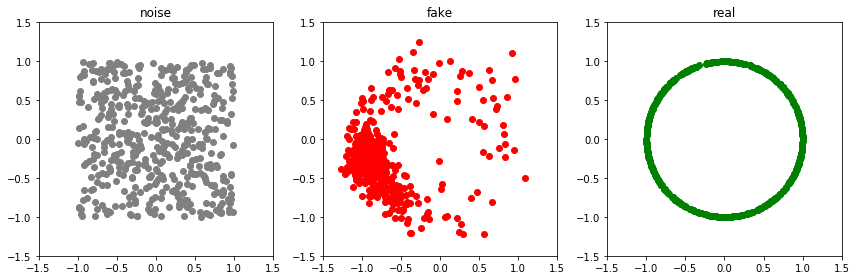

Epoch: 8000 G-error: 3.487762212753296 D-error: 0.3378257751464844


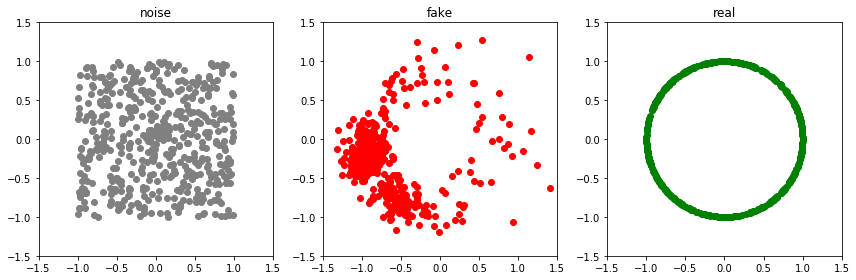

Epoch: 8100 G-error: 3.86464786529541 D-error: 0.33962270617485046


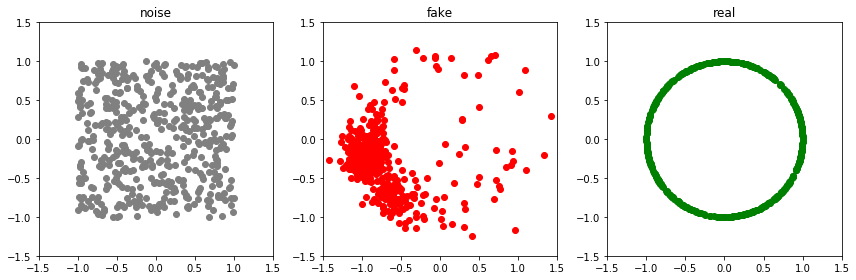

Epoch: 8200 G-error: 4.061293601989746 D-error: 0.31160640716552734


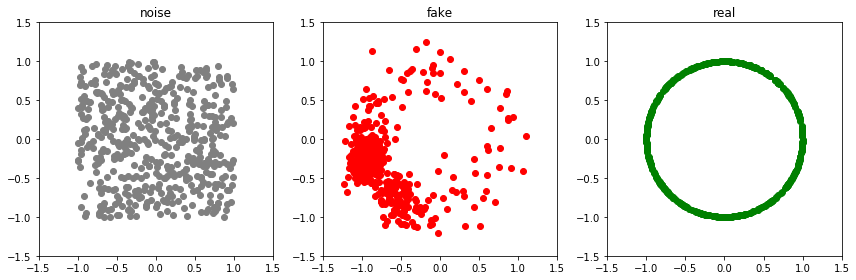

Epoch: 8300 G-error: 3.2875702381134033 D-error: 0.3430655598640442


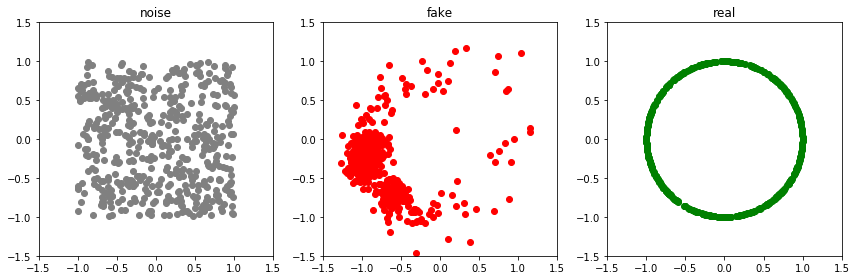

Epoch: 8400 G-error: 3.2883529663085938 D-error: 0.3206937909126282


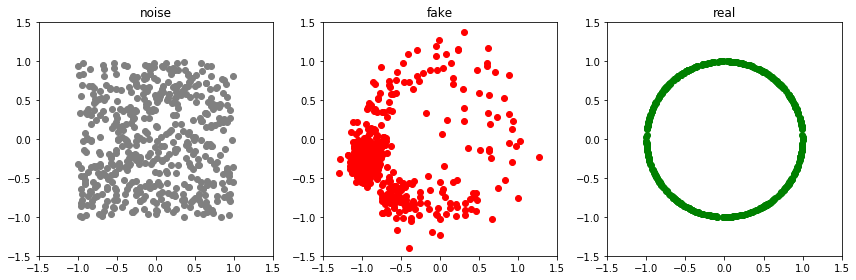

Epoch: 8500 G-error: 3.6296260356903076 D-error: 0.32808226346969604


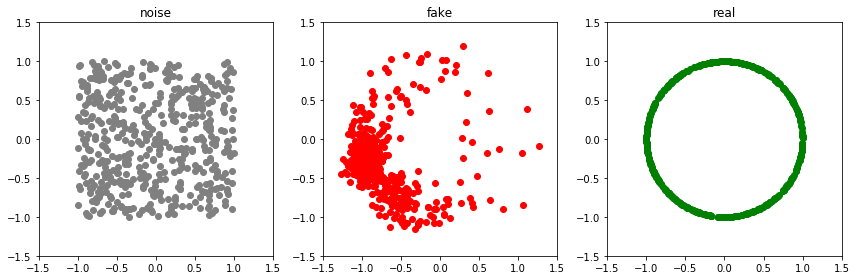

Epoch: 8600 G-error: 3.4763996601104736 D-error: 0.31222081184387207


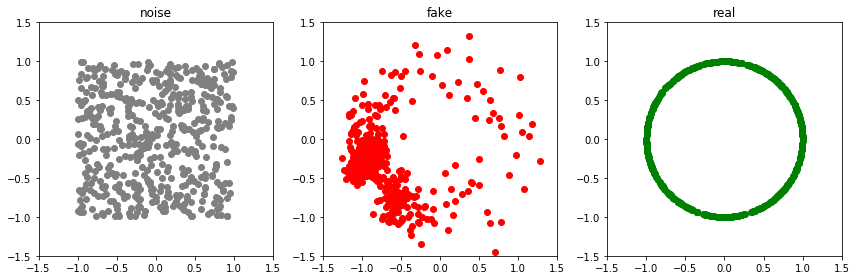

Epoch: 8700 G-error: 3.5997650623321533 D-error: 0.336041659116745


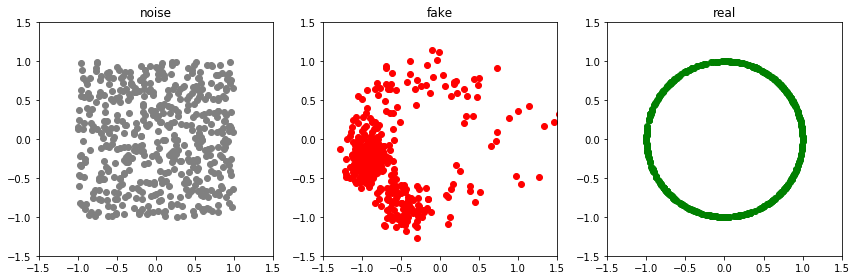

Epoch: 8800 G-error: 3.8431713581085205 D-error: 0.32251638174057007


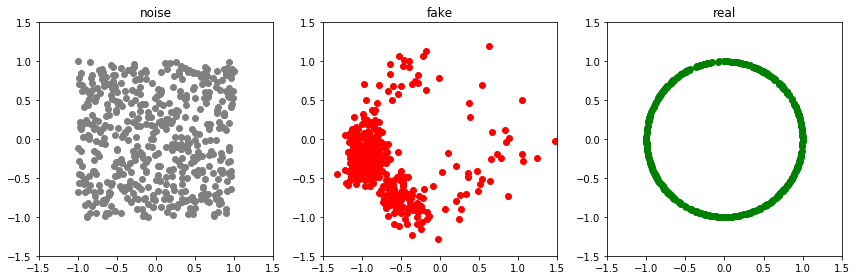

Epoch: 8900 G-error: 3.5631356239318848 D-error: 0.33824917674064636


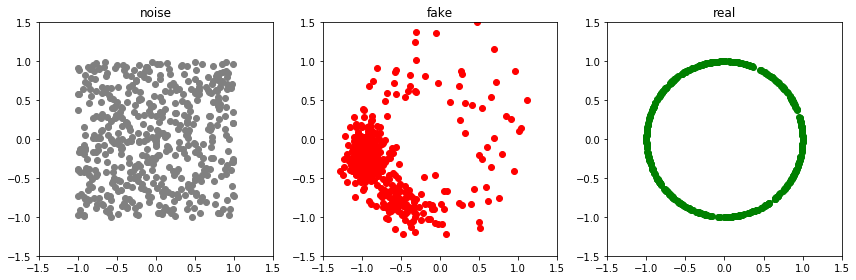

Epoch: 9000 G-error: 3.562969446182251 D-error: 0.3291047215461731


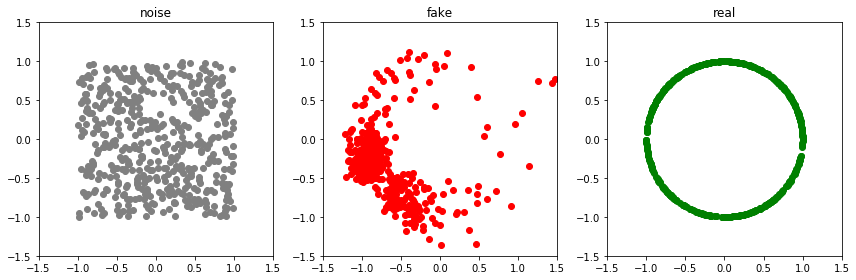

Epoch: 9100 G-error: 3.230684757232666 D-error: 0.34292614459991455


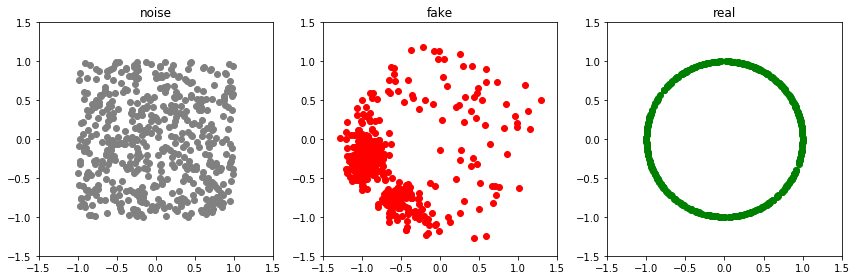

Epoch: 9200 G-error: 3.6741223335266113 D-error: 0.30890119075775146


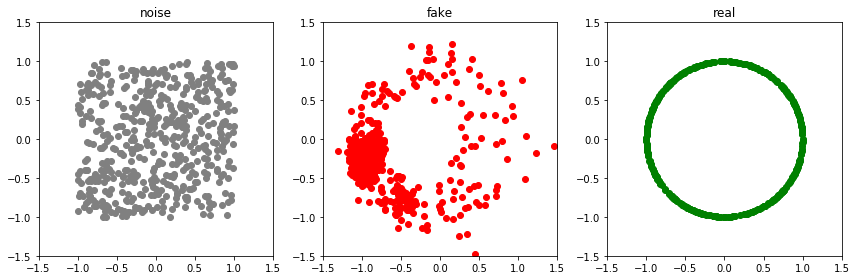

Epoch: 9300 G-error: 3.749498128890991 D-error: 0.3123173713684082


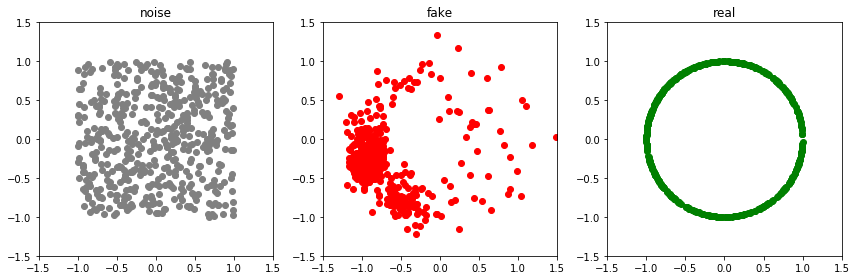

Epoch: 9400 G-error: 3.817556381225586 D-error: 0.3480006456375122


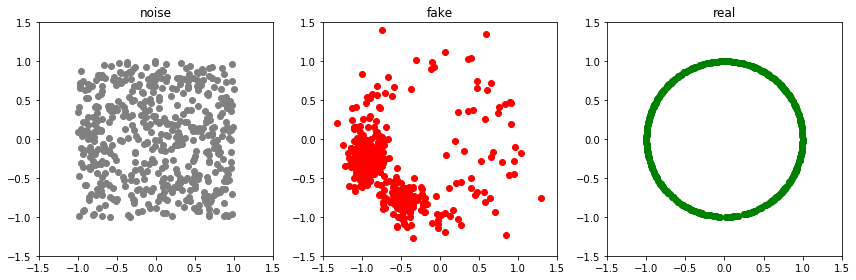

Epoch: 9500 G-error: 3.375607967376709 D-error: 0.2982461154460907


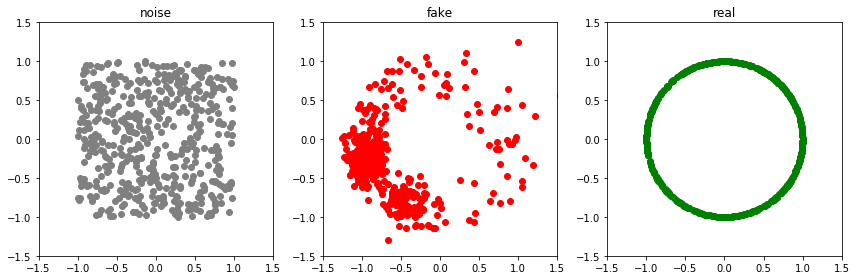

Epoch: 9600 G-error: 3.504263162612915 D-error: 0.3159165382385254


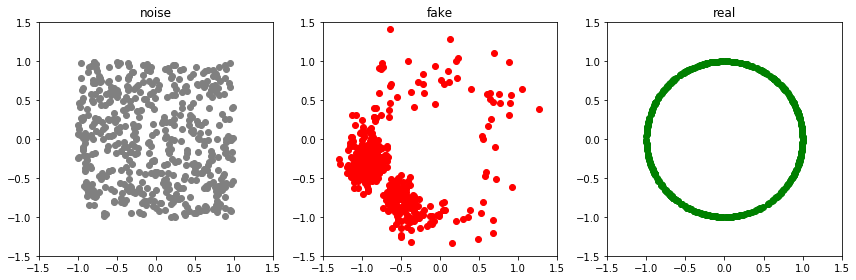

Epoch: 9700 G-error: 3.5507800579071045 D-error: 0.26976945996284485


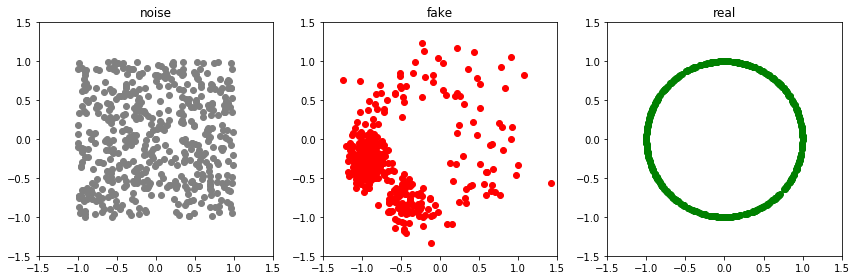

Epoch: 9800 G-error: 3.8692996501922607 D-error: 0.29700252413749695


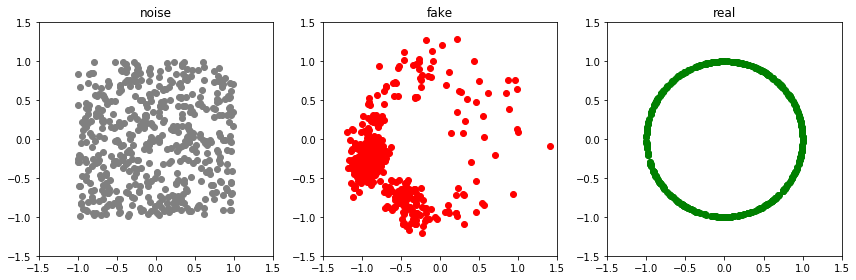

Epoch: 9900 G-error: 3.5896224975585938 D-error: 0.29550474882125854


In [17]:
num_epochs = 10000
sample_size = 500

for epoch in range(num_epochs):
    
    # real data
    angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
    data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
    real_data = t.from_numpy(data)
    
    # train discriminator:
    noise = t.empty(sample_size,2, device=device).uniform_(-1,-1)  
    fake_data = generator(noise)  
    d_error = train_discriminator(d_optimizer, real_data, fake_data)
    

    # train generator     
    noise = t.empty(sample_size,2, device=device).uniform_(-1,1)  
    fake_data = generator(noise)  
    g_error = train_generator(g_optimizer, fake_data)
 
    
    if epoch%100 ==0:
        show(noise, fake_data, real_data)
        print(f"Epoch: {epoch} G-error: {g_error.item()} D-error: {d_error.item()}")


## Final result

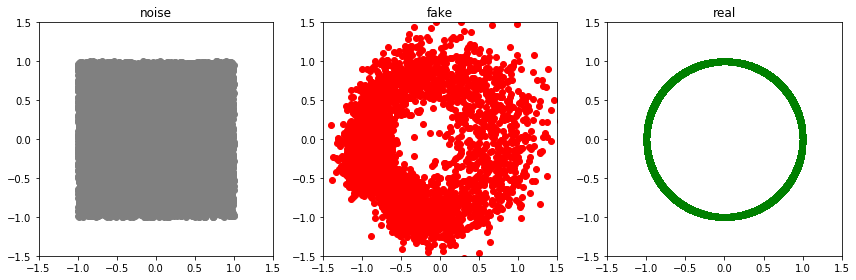

In [19]:
sample_size = 10000

angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
real_data = t.from_numpy(data)
    
    #fake data:
noise = t.empty(sample_size,2, device=device).uniform_(-1,1)
fake_data = generator(noise).detach()

show(noise, fake_data, real_data)

## Saving the model

In [23]:
t.save(discriminator, "discriminator")
t.save(generator, "generator")

model_d = t.load("discriminator")
model_g = t.load("generator")

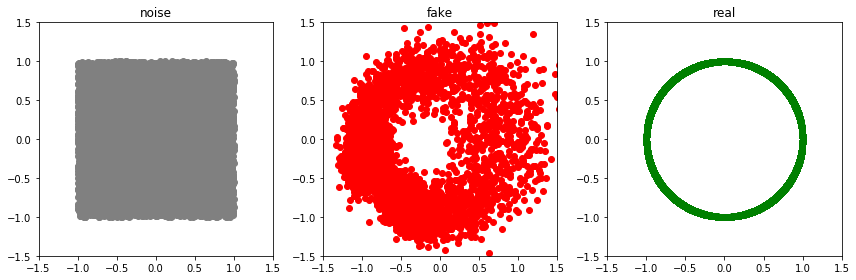

In [24]:
sample_size = 10000
angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
real_data = t.from_numpy(data)
    
#fake data:
noise = t.empty(sample_size,2, device=device).uniform_(-1,1)
fake_data = model_g(noise).detach()

show(noise, fake_data, real_data)

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

### Problem 2

Use another sampling distribution. One that is not concentrated on a line e.g. an ellipse. 